In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.data.Dataset.range(10)

In [3]:
for i in dataset:
    print(i, i.numpy())

tf.Tensor(0, shape=(), dtype=int64) 0
tf.Tensor(1, shape=(), dtype=int64) 1
tf.Tensor(2, shape=(), dtype=int64) 2
tf.Tensor(3, shape=(), dtype=int64) 3
tf.Tensor(4, shape=(), dtype=int64) 4
tf.Tensor(5, shape=(), dtype=int64) 5
tf.Tensor(6, shape=(), dtype=int64) 6
tf.Tensor(7, shape=(), dtype=int64) 7
tf.Tensor(8, shape=(), dtype=int64) 8
tf.Tensor(9, shape=(), dtype=int64) 9


In [4]:
dataset = dataset.window(5, shift=1, drop_remainder=True)

In [5]:
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


Split data into series and labels

In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x,y  in dataset:
    print("x=", x.numpy()) 
    print("y=", y.numpy())

x= [[0 1 2 3]
 [1 2 3 4]]
y= [[4]
 [5]]
x= [[4 5 6 7]
 [3 4 5 6]]
y= [[8]
 [7]]
x= [[5 6 7 8]
 [2 3 4 5]]
y= [[9]
 [6]]


Feeding windowed dataset into neural nerwork

In [8]:
tf.random.uniform([2, 3])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.82353497, 0.8461542 , 0.91590464],
       [0.63233316, 0.47626722, 0.5805031 ]], dtype=float32)>

In [10]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    [tf.random.uniform([2, 3]), tf.random.uniform([2, 3])])

In [13]:
for elem in dataset1:
    print(elem.numpy())

[[0.00857925 0.24833739 0.35513806]
 [0.5149429  0.94314635 0.41585708]]
[[0.03465891 0.598874   0.94557834]
 [0.64160514 0.0311662  0.22087967]]


In [15]:
dataset2 = tf.data.Dataset.from_tensors(
    [tf.random.uniform([2, 3]), tf.random.uniform([2, 3])])

In [16]:
for elem in dataset1:
    print(elem.numpy())

[[0.00857925 0.24833739 0.35513806]
 [0.5149429  0.94314635 0.41585708]]
[[0.03465891 0.598874   0.94557834]
 [0.64160514 0.0311662  0.22087967]]


In [17]:
print(dataset1)

<TensorSliceDataset shapes: (2, 3), types: tf.float32>


In [18]:
print(dataset2)

<TensorDataset shapes: (2, 2, 3), types: tf.float32>


In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Split data into training and validation set

In [24]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

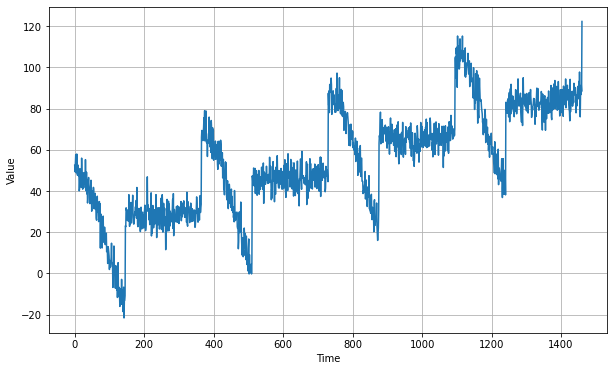

In [26]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [27]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_val = time[split_time:]
x_valid = series[split_time:]

In [28]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [31]:
for elem in dataset:
    print(elem)

(<tf.Tensor: shape=(32, 20), dtype=float32, numpy=
array([[32.37862   , 28.28001   , 35.455605  , 26.838215  , 41.736534  ,
        31.238834  , 23.800137  , 22.7075    , 30.450966  , 26.898535  ,
        31.563684  , 30.338299  , 27.586983  , 23.696756  , 20.33666   ,
        25.659061  , 32.15494   , 28.92529   , 21.608559  , 28.686138  ],
       [37.56802   , 53.691013  , 45.266438  , 43.935593  , 41.0233    ,
        37.823654  , 50.228203  , 46.493633  , 39.692234  , 39.681923  ,
        44.49395   , 54.533825  , 44.906883  , 38.70553   , 45.0092    ,
        44.891247  , 32.78765   , 46.018097  , 45.15265   , 49.806374  ],
       [68.57505   , 63.09382   , 64.34379   , 65.262314  , 54.023083  ,
        63.007553  , 60.845512  , 59.259632  , 62.87484   , 73.28169   ,
        67.5107    , 61.464104  , 67.19674   , 71.34472   , 68.98551   ,
        64.6752    , 61.15736   , 67.89844   , 66.390305  , 68.91469   ],
       [94.84867   , 91.54276   , 77.20444   , 79.93713   , 83.12551  

In [33]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [34]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [45]:
print(f"Layer weights {l0.get_weights()}")

Layer weights [array([[ 1.7226256e-03],
       [-6.8457566e-02],
       [ 7.5562581e-02],
       [-4.1343533e-02],
       [ 7.9431854e-02],
       [-4.4527821e-02],
       [-1.6131390e-02],
       [ 7.4319383e-03],
       [ 1.1097631e-02],
       [-5.7546305e-05],
       [-7.0583303e-03],
       [ 2.7572026e-02],
       [-4.5897946e-02],
       [ 8.0374658e-02],
       [-1.7422978e-02],
       [ 5.9154123e-02],
       [ 4.3827915e-03],
       [ 2.4474819e-01],
       [ 2.1700476e-01],
       [ 4.4586793e-01]], dtype=float32), array([0.01551414], dtype=float32)]


In [35]:
print(series[1:21])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


In [38]:
series[1:21].shape

(20,)

In [39]:
series[1:21][np.newaxis].shape

(1, 20)

In [40]:
series[1:21][np.newaxis]

array([[49.35275 , 53.314735, 57.711823, 48.934444, 48.931244, 57.982895,
        53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374, 50.959415,
        40.086178, 40.919415, 46.612473, 44.228207, 50.720642, 44.454983,
        41.76799 , 55.980938]], dtype=float32)

In [41]:
model.predict(series[1:21][np.newaxis])

array([[49.609547]], dtype=float32)

In [42]:
series[22]

48.6033

In [43]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.000135

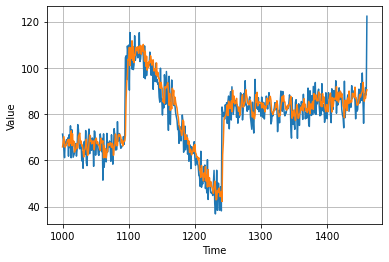

In [47]:
plot_series(time_val, x_valid)
plot_series(time_val, results)